## GreyWolf Optimizer

In [ ]:
!pip install numpy
!pip install matplotlib

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import datetime
import time

In [ ]:
class wolf:
    
    def __init__(self, dim):
        self.position = 100 * np.random.rand(dim)
        self.obj_score = float('inf')

In [ ]:
def GWO(obj_fun, soln_dim, wolves_n, iter_n):
    
    # obj_fun   - objective function to be minimized
    # soln_dim  - dimension of solution vector
    # wolves_n  - no. of searching wolves
    # iter_n    - no of iterations
    
    wolves = []
    
    # 1] Initialize positions of wolves randomly
    
    for i in range(wolves_n):
        w = wolf(soln_dim)
        #print(w.position)
        wolves.append(w)
    
    alpha , beta, delta = wolves[:3]
    
    score_history = {
        'alpha' : [],
        'beta' : [],
        'delta' : []
    }
    
    # 2] Loop 3-4  iter_n times
    
    for i in range(iter_n):
        
    #   3] Calculate objective function for all wolves and find best 3 alpha, beta & gamma
        
        for w in wolves:
            w.obj_score = obj_fun(w.position)
            
            if w.obj_score <= alpha.obj_score:
                delta = beta
                beta = alpha
                alpha = w
            
            elif w.obj_score <= beta.obj_score:
                delta = beta
                beta = w
                
            elif w.obj_score <= delta.obj_score:
                delta = w
                
        score_history['alpha'].append(alpha.obj_score)
        score_history['beta'].append(beta.obj_score)
        score_history['delta'].append(delta.obj_score)
        
        
    #   4] Update positions of rest of wolves based on GWO mathematical formula
    
        # a decreases linearly from 2 to 0 as iteration proceeds
        a = 2 * (1 - (i/iter_n))
        
        for w in wolves:
            
            # r1 & r2 are random vectors in [0, 1]
            r1 = np.random.rand(soln_dim)
            r2 = np.random.rand(soln_dim)
            
            A1 = a * ((2 * r1) - 1)
            C1 = 2 * r2
            
            D_alpha = abs((C1 * alpha.position) - w.position) 
            X1 = alpha.position - (A1 * D_alpha)
            
            
            r1 = np.random.rand(soln_dim)
            r2 = np.random.rand(soln_dim)
            
            A2 = a * ((2 * r1) - 1)
            C2 = 2 * r2

            D_beta = abs((C2 * beta.position) - w.position) 
            X2 = beta.position - (A2 * D_beta)
            
            
            r1 = np.random.rand(soln_dim)
            r2 = np.random.rand(soln_dim)
            
            A3 = a * ((2 * r1) - 1)
            C3 = 2 * r2

            D_delta = abs((C3 * delta.position) - w.position) 
            X3 = delta.position - (A3 * D_delta)
            
            w.position = (X1 + X2 + X3)/3
    
    # 5] Return best solution (alpha)
    
    return alpha, score_history
    

In [ ]:
def dummy_obj_fun(sol):
    return sum(sol*sol)

In [ ]:
soln_dim = 3
wolves_n = 10
iter_n = 20

best, history = GWO(dummy_obj_fun, soln_dim=soln_dim, wolves_n=wolves_n, iter_n=iter_n)
best.position

array([ 5.58075663, -3.95418431,  5.16002573])

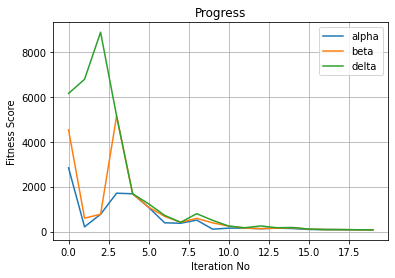

In [ ]:
plt.plot(np.array(history['alpha']) ,label='alpha')
plt.plot(np.array(history['beta']), label='beta')
plt.plot(np.array(history['delta']), label='delta')
plt.xlabel("Iteration No")
plt.ylabel("Fitness Score")
plt.title('Progress')
plt.grid()
plt.legend()
plt.savefig("graph")

In [ ]:
print(history['alpha'])
print(history['beta'])
print(history['delta'])

[2839.142025174588, 208.23609638169023, 769.4264865735095, 1708.021481471192, 1682.9700152440919, 1077.3310064823904, 387.9062121829777, 368.0991624643443, 509.49285625801366, 103.39549245141474, 151.35633013278036, 150.6864302668176, 124.06288421923006, 150.73715963225038, 132.24192784894404, 91.29359785797558, 82.7480869607771, 83.95485374513632, 75.48324242518126, 71.2215124802129]
[4533.148720200277, 596.3126328531131, 769.4264865735095, 5151.6281412800745, 1684.426739325084, 1084.7574462822704, 673.8792775199515, 410.94629217163515, 588.2892643446609, 384.7459462815756, 242.25224398595054, 150.6864302668176, 128.85737593006124, 150.73715963225038, 166.85261988750153, 104.92133301618847, 88.07209378292961, 84.90900192490204, 78.99047573313392, 73.50625047120961]
[6155.799836781219, 6787.617027478396, 8885.273952716334, 5151.6281412800745, 1684.426739325084, 1235.4460431769978, 719.4688171422264, 410.94629217163515, 795.0035286942745, 497.32179185527787, 242.25224398595054, 167.8672

## Binary GWO

In [ ]:
# sigmoid fun
def sigmoid(x):
  return 1/(1 + np.exp( (-10) * (x - 0.5) ))

In [ ]:
class Wolf:

  def __init__(self, dim):

    pos = sigmoid(np.random.rand(dim)) >= 0.5

    # To avoid all zero condition
    while(np.count_nonzero(pos)==0):
      pos = sigmoid(np.random.rand(dim)) >= 0.5

    self.position = pos
    self.obj_score = float('inf')
    self.obj_fun_time = None

Wolf(9).position

array([ True, False,  True,  True,  True, False,  True,  True,  True])

In [ ]:
class BinaryGWO:
  
  def __init__(self, obj_fun, dim, wolves_n, iter_n):
    self.obj_fun = obj_fun
    self.dim = dim
    self.wolves_n = wolves_n
    self.iter_n = iter_n

    self.score_history = {
        'alpha' : [],
        'beta' : [],
        'delta' : []
    }

    self.wolves = []
    self.alpha = None
    self.beta = None
    self.delta = None


  def initialize_wolves(self):
    self.wolves = []

    for i in range(self.wolves_n):
      w = Wolf(self.dim)
      #print(w.position)
      self.wolves.append(w)
    
    self.alpha, self.beta, self.delta = self.wolves[:3]
  

  def update_leaders(self):
    for w in self.wolves:

      if w==self.alpha or w==self.beta or w==self.delta:
        continue

      print(f'Position : {w.position}')
      a = datetime.datetime.now()
      w.obj_score = self.obj_fun(w.position)
#     time.sleep(.2)
      b = datetime.datetime.now()
      w.obj_fun_time = b-a
        
      if w.obj_score <= self.alpha.obj_score:
          self.delta = self.beta
          self.beta = self.alpha
          self.alpha = w
        
      elif w.obj_score <= self.beta.obj_score:
          self.delta = self.beta
          self.beta = w
            
      elif w.obj_score <= self.delta.obj_score:
          self.delta = w
            
    self.score_history['alpha'].append(self.alpha.obj_score)
    self.score_history['beta'].append(self.beta.obj_score)
    self.score_history['delta'].append(self.delta.obj_score)

    print(f'alpha pos: {self.alpha.position}\tscore : {self.alpha.obj_score}')
    print(f'beta pos: {self.beta.position}\tscore : {self.beta.obj_score}')
    print(f'delta pos: {self.delta.position}\tscore : {self.delta.obj_score}')


  def print_wolf_time(self) :
    for w in self.wolves:
        print('Time => ', w.obj_fun_time)

  def update_positions(self, i):

    a = 2 * (1 - (i/self.iter_n))
        
    for w in self.wolves:

      if w==self.alpha or w==self.beta or w==self.delta:
        continue
            
      # r1 & r2 are random vectors in [0, 1]
      r1 = np.random.rand(self.dim)
      r2 = np.random.rand(self.dim)
            
      A1 = a * ((2 * r1) - 1)
      C1 = 2 * r2
          
      D_alpha = abs((C1 * self.alpha.position) - w.position)

      c_step_alpha = sigmoid(A1 * D_alpha)
      b_step_alpha = c_step_alpha >= np.random.rand(self.dim)
      X1 = ((self.alpha.position + b_step_alpha) >= 1)
      #X1 = alpha.position - (A1 * D_alpha)
            
            
      r1 = np.random.rand(self.dim)
      r2 = np.random.rand(self.dim)
            
      A2 = a * ((2 * r1) - 1)
      C2 = 2 * r2

      D_beta = abs((C2 * self.beta.position) - w.position) 

      c_step_beta = sigmoid(A2 * D_beta)
      b_step_beta = c_step_beta >= np.random.rand(self.dim)
      X2 = ((self.beta.position + b_step_beta) >= 1)
      #X2 = beta.position - (A2 * D_beta)
            
            
      r1 = np.random.rand(self.dim)
      r2 = np.random.rand(self.dim)
            
      A3 = a * ((2 * r1) - 1)
      C3 = 2 * r2

      D_delta = abs((C3 * self.delta.position) - w.position)

      c_step_delta = sigmoid(A3 * D_delta)
      b_step_delta = c_step_delta >= np.random.rand(self.dim)
      X3 = ((self.delta.position + b_step_delta) >= 1)
      #X3 = delta.position - (A3 * D_delta)
      
      updated_position = (sigmoid( (X1 + X2 + X3)/3 ) >= np.random.rand(self.dim))

      if np.count_nonzero(updated_position) != 0:
        w.position = updated_position

    

  def optimize(self):

    self.initialize_wolves()

    self.score_history = {
        'alpha' : [],
        'beta' : [],
        'delta' : []
    }

    for i in range(self.iter_n):
      print('\n=> Iteration : ', i)
      self.update_leaders()
      self.update_positions(i)


### ANN Model

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
inFile = "/content/gdrive/My Drive/Colab Notebooks/GWO/Dataset/winequality-red.csv"
data = pd.read_csv(inFile)

In [ ]:
def mape_calc(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

In [ ]:
def smape(a, f):
    return 1/len(a) * np.sum(2 * np.abs(f-a) / (np.abs(a) + np.abs(f))*100)

In [ ]:
def test_model(selected_features_index):

  X = data.drop("quality", axis = 1)
  y = data["quality"]

  selected_features = []
  cols = X.columns
  for index in range(len(selected_features_index)):
    if selected_features_index[index] == 1:
      selected_features.append(cols[index])  

  for i in range(len(cols)):
    k = cols[i]
    if k not in selected_features:
      X = X.drop(columns = k)
  scaler = StandardScaler()
  scaler.fit(X)
  X_scaled = scaler.transform(X) 

  X_train, X_test, y_train, y_test = train_test_split(X_scaled,y, test_size=0.3, random_state=42)

  tf.random.set_seed(42)

  model = tf.keras.Sequential([
                               tf.keras.layers.Dense(100,activation='relu'),
                               tf.keras.layers.Dense(100,activation='relu'),
                               tf.keras.layers.Dense(100,activation='relu'),
                               tf.keras.layers.Dense(10),
                               tf.keras.layers.Dense(1)

  ])

  model.compile(loss=tf.keras.losses.mape,
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
                metrics=['mape'])

  history = model.fit(X_train,y_train, epochs=355,verbose=0)

  loss, mape = model.evaluate(X_test,y_test)
  print(f'loss: {loss}, accuracy: {100-mape}')

  y_pred = model.predict(X_test)

  y_pred = np.asarray(y_pred).reshape(480,1)
  y_test = np.asarray(y_test).reshape(480,1)

  error = y_pred-y_test
  test_error = mape_calc(y_test,y_pred)
  print(f'Test Error : {test_error}')
  return test_error

### Testing Binary GWO

In [ ]:
bgwo = BinaryGWO(obj_fun = test_model, dim = 11, wolves_n=10, iter_n = 7)

In [ ]:
bgwo.optimize()


=> Iteration :  0
Position : [False False  True  True  True False  True False  True False  True]
15/15 [==============================] - 0s 2ms/step - loss: 9.5839 - mape: 9.5839
loss: 9.583910942077637, accuracy: 90.41608905792236
Test Error : 9.583911640540002
Position : [False False  True  True False False  True False  True  True False]
15/15 [==============================] - 0s 2ms/step - loss: 10.0346 - mape: 10.0346
loss: 10.034581184387207, accuracy: 89.9654188156128
Test Error : 10.034580815051283
Position : [False  True  True False False False False False  True False  True]
15/15 [==============================] - 0s 2ms/step - loss: 8.8539 - mape: 8.8539
loss: 8.85387897491455, accuracy: 91.14612102508545
Test Error : 8.85387856335867
Position : [ True  True  True  True False False  True  True False  True  True]
15/15 [==============================] - 0s 2ms/step - loss: 8.4827 - mape: 8.4827
loss: 8.482748985290527, accuracy: 91.51725101470947
Test Error : 8.482748538255